<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/Module_9_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


One of the major benefits of transfer learning is transferring learned feature extraction to the
new model so that model training can start from a learned state, be faster, and sometimes
better than the original. Let us try to show if this really works by an experiment.
1. [20 pts] Using full MNIST dataset provided in the course, filter half of the digits grouped by
labels from the training dataset. The filtered subset dataset should only contain five of the
original ten labels. Pick the set of labels in such a way that if a feature to be extracted from
the data points of that label it will be compensated by another label. For example, label 3
and label 8 might have similar features. Another example could be label 0 and label 9.
2. [30 pts] Pick and train a model with half of the training dataset created in question (1.).
Report its testing performance on the MNIST testing dataset. Use a previously working
model in your experience. Especially a convolutional network would be very helpful.
3. [30 pts] Use the first model to train a second model while fixing the feature extraction. Use
the entire training dataset this time. Report model performance on the full testing dataset.
Now train a third model and do not fix the feature extraction, and report its performance.
Compare these performances.
4. [20 pts] Discuss the outcome you observed in (3.). Did the transfer learning work?


In [4]:
# Check if CUDA is available and set the device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Step 1: Creating a Subset of the MNIST Dataset
First, we'll load the MNIST dataset and create a subset containing only the digits 0, 2, 3, 7, and 9.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the subset of labels we want to keep
subset_labels = [0, 2, 3, 7, 9]

# Filter the training dataset to only include the specified labels
subset_indices = [i for i, (image, label) in enumerate(train_dataset) if label in subset_labels]

# Create a subset of the training dataset
subset_train_dataset = Subset(train_dataset, subset_indices)

# Create data loaders
train_loader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 78951817.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28125306.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71790018.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3501291.82it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Step 2: Training the First Model
Now we'll define and train a RESNET CNN model on the subset of the MNIST dataset.

In [7]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# MNIST images are 1 channel (grayscale), ResNet expects 3 channels (RGB)
# We will modify the first convolutional layer to accept 1 channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training function
# Training function
# Training function that records the loss
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Record the loss
        train_losses.append(loss.item())

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



# Training loop
train_losses = []
for epoch in range(1, 30):
    train(model, device, train_loader, optimizer, epoch, train_losses)

Train Epoch: 1 [0/30226 (0%)]	Loss: 2.776441
Train Epoch: 1 [640/30226 (2%)]	Loss: 0.417382
Train Epoch: 1 [1280/30226 (4%)]	Loss: 0.060499
Train Epoch: 1 [1920/30226 (6%)]	Loss: 0.174871
Train Epoch: 1 [2560/30226 (8%)]	Loss: 0.011549
Train Epoch: 1 [3200/30226 (11%)]	Loss: 0.156855
Train Epoch: 1 [3840/30226 (13%)]	Loss: 0.159677
Train Epoch: 1 [4480/30226 (15%)]	Loss: 0.152760
Train Epoch: 1 [5120/30226 (17%)]	Loss: 0.033954
Train Epoch: 1 [5760/30226 (19%)]	Loss: 0.014891
Train Epoch: 1 [6400/30226 (21%)]	Loss: 0.133742
Train Epoch: 1 [7040/30226 (23%)]	Loss: 0.021008
Train Epoch: 1 [7680/30226 (25%)]	Loss: 0.023609
Train Epoch: 1 [8320/30226 (27%)]	Loss: 0.021809
Train Epoch: 1 [8960/30226 (30%)]	Loss: 0.014345
Train Epoch: 1 [9600/30226 (32%)]	Loss: 0.104266
Train Epoch: 1 [10240/30226 (34%)]	Loss: 0.037860
Train Epoch: 1 [10880/30226 (36%)]	Loss: 0.014158
Train Epoch: 1 [11520/30226 (38%)]	Loss: 0.060089
Train Epoch: 1 [12160/30226 (40%)]	Loss: 0.019261
Train Epoch: 1 [12800/302

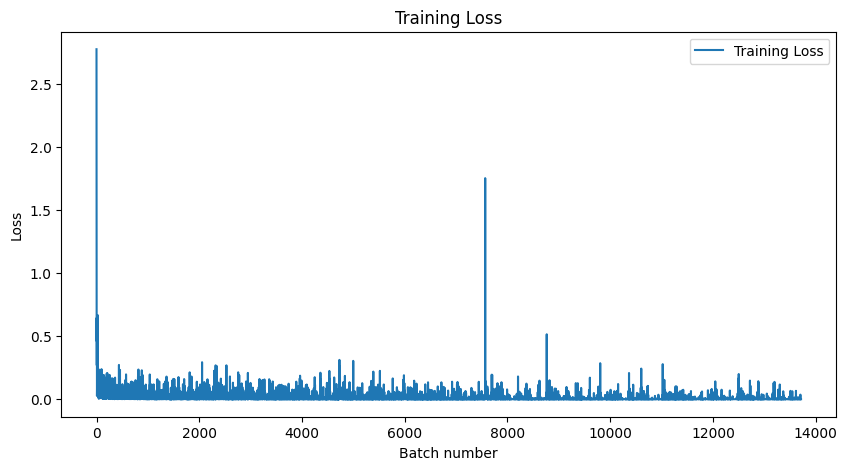

In [8]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test set: Average loss: 0.1301, Accuracy: 5042/10000 (50%)



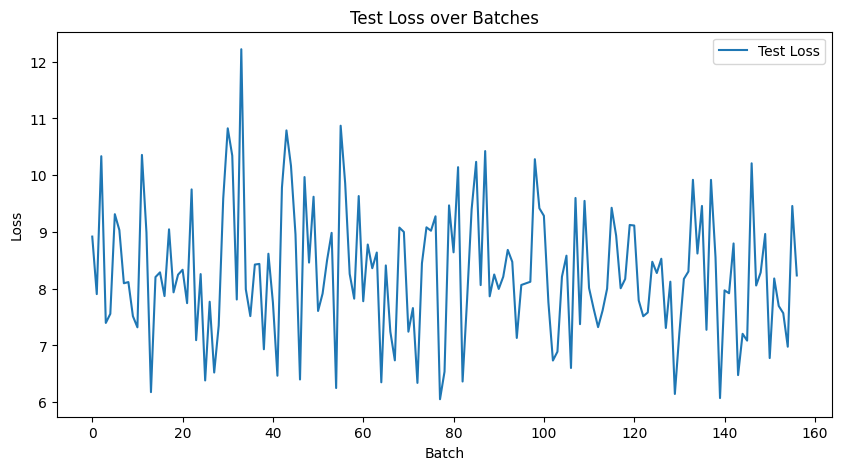

In [9]:
#Compute and Plot test loss
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate the model and plot the test loss
evaluate_and_plot_loss(model, device, test_loader)


. [30 pts] Use the first model to train a second model while fixing the feature extraction. Use
the entire training dataset this time. Report model performance on the full testing dataset.
Now train a third model and do not fix the feature extraction, and report its performance.
Compare these performances.
4. [20 pts] Discuss the outcome you observed in (3.). Did the transfer learning work?


In [10]:
torch.save(model.state_dict(), 'model.pth')

model = model.load_state_dict(torch.load('model.pth'))

In [11]:

# Freeze the convolutional layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layers
for param in model.fc.parameters():
    param.requires_grad = True

# Replace the top layer for MNIST classification (if not already done)
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
# Only optimize the parameters of the fully connected layers
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

# Training function that records the loss
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Record the loss
        train_losses.append(loss.item())

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



# Training loop
train_losses = []

# Training loop
train_losses = []
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch, train_losses)




Train Epoch: 1 [0/30226 (0%)]	Loss: 2.345680
Train Epoch: 1 [640/30226 (2%)]	Loss: 0.235326
Train Epoch: 1 [1280/30226 (4%)]	Loss: 0.072283
Train Epoch: 1 [1920/30226 (6%)]	Loss: 0.045093
Train Epoch: 1 [2560/30226 (8%)]	Loss: 0.017104
Train Epoch: 1 [3200/30226 (11%)]	Loss: 0.022573
Train Epoch: 1 [3840/30226 (13%)]	Loss: 0.012622
Train Epoch: 1 [4480/30226 (15%)]	Loss: 0.019695
Train Epoch: 1 [5120/30226 (17%)]	Loss: 0.005899
Train Epoch: 1 [5760/30226 (19%)]	Loss: 0.032600
Train Epoch: 1 [6400/30226 (21%)]	Loss: 0.025812
Train Epoch: 1 [7040/30226 (23%)]	Loss: 0.011435
Train Epoch: 1 [7680/30226 (25%)]	Loss: 0.023380
Train Epoch: 1 [8320/30226 (27%)]	Loss: 0.012101
Train Epoch: 1 [8960/30226 (30%)]	Loss: 0.015598
Train Epoch: 1 [9600/30226 (32%)]	Loss: 0.005022
Train Epoch: 1 [10240/30226 (34%)]	Loss: 0.005676
Train Epoch: 1 [10880/30226 (36%)]	Loss: 0.010507
Train Epoch: 1 [11520/30226 (38%)]	Loss: 0.008719
Train Epoch: 1 [12160/30226 (40%)]	Loss: 0.005575
Train Epoch: 1 [12800/302

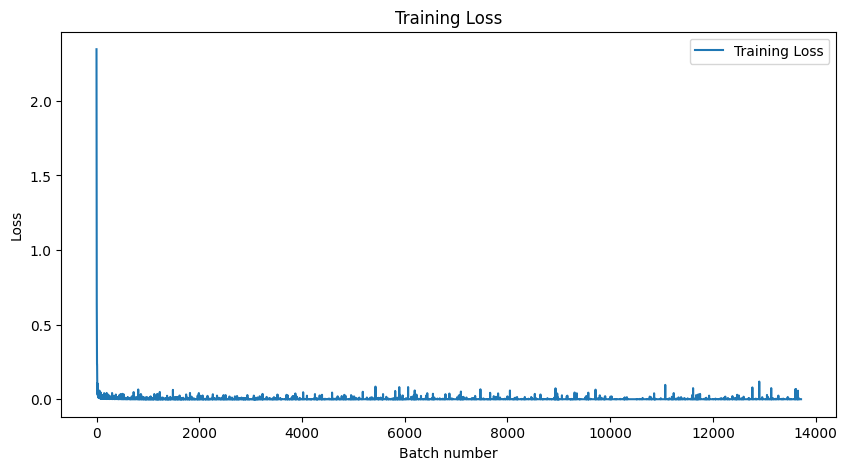

In [12]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test set: Average loss: 0.1258, Accuracy: 5042/10000 (50%)



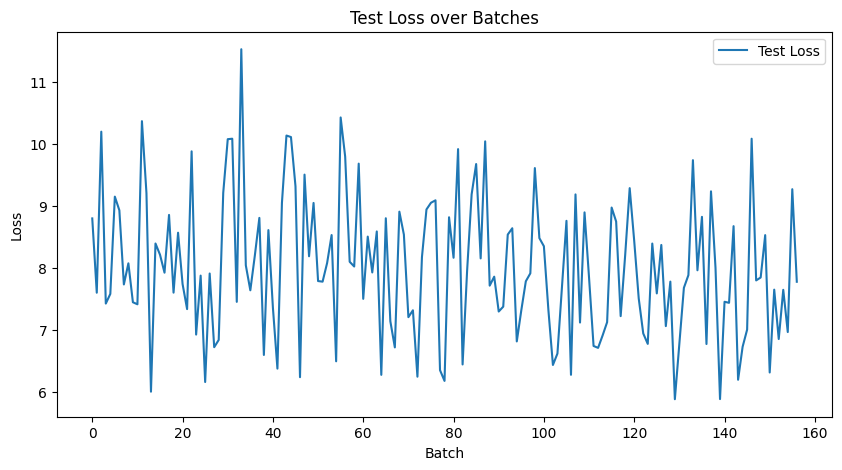

In [13]:
#Compute and Plot test loss
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate the model and plot the test loss
evaluate_and_plot_loss(model, device, test_loader)

Now train a third model and do not fix the feature extraction, and report its performance.
Compare these performances.

In [14]:
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




In [16]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# MNIST images are 1 channel (grayscale), ResNet expects 3 channels (RGB)
# We will modify the first convolutional layer to accept 1 channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training function
# Training function
# Training function that records the loss
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Record the loss
        train_losses.append(loss.item())

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
train_losses = []
for epoch in range(1, 30):
    train(model, device, train_loader, optimizer, epoch, train_losses)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.901299
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.833697
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.390770
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.385048
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.237378
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.527431
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.065555
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.223099
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.061638
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.174858
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.139118
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.135176
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.155839
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.269619
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.061795
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.100445
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.238573
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.044929
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.168206
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.156335
Train Epoch: 1 [12800/60000 (

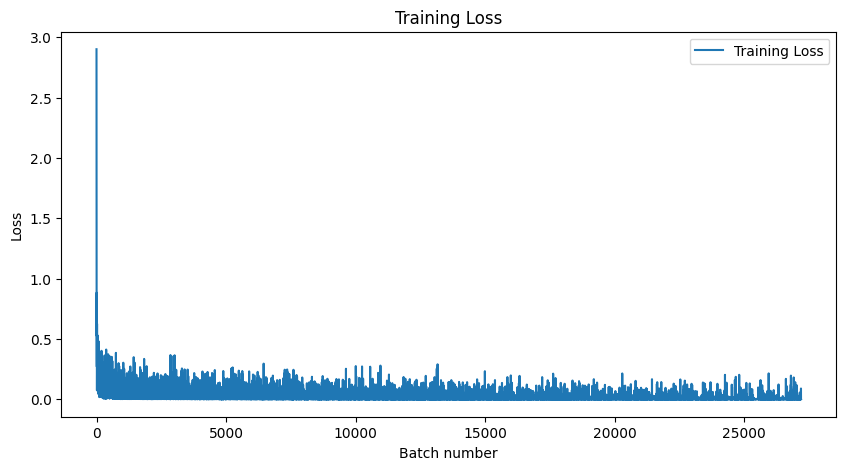

In [17]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test set: Average loss: 0.0004, Accuracy: 9938/10000 (99%)



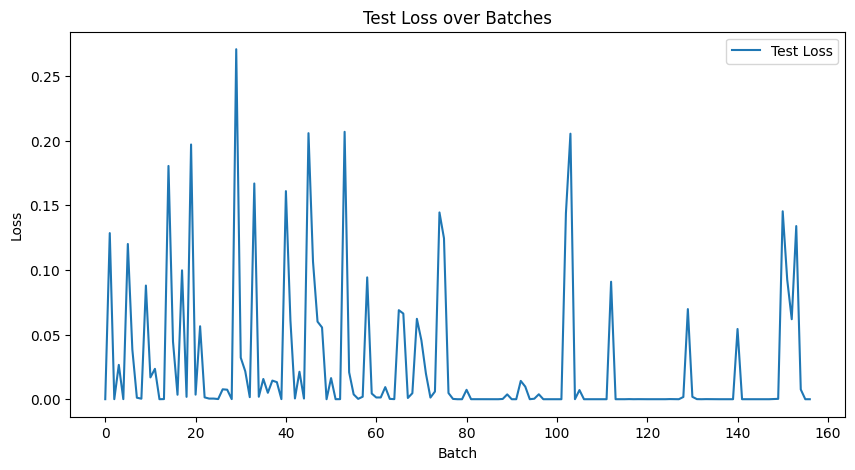

In [18]:
#Compute and Plot test loss
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate the model and plot the test loss
evaluate_and_plot_loss(model, device, test_loader)